In [1]:
import pandas as pd
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [2]:
with open(r'../../data/pca_data_scaled.pkl', 'rb') as f:
    data = pickle.load(f)

In [3]:
X_train_std = data['X_train_std']
X_test_std = data['X_test_std']

X_train_minmax = data['X_train_minmax']
X_test_minmax = data['X_test_minmax']

X_train_robust = data['X_train_robust']
X_test_robuts = data['X_test_robust']


y_train = data['y_train']
y_test = data['y_test']

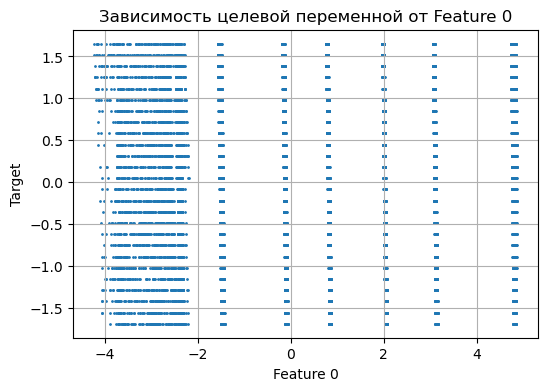

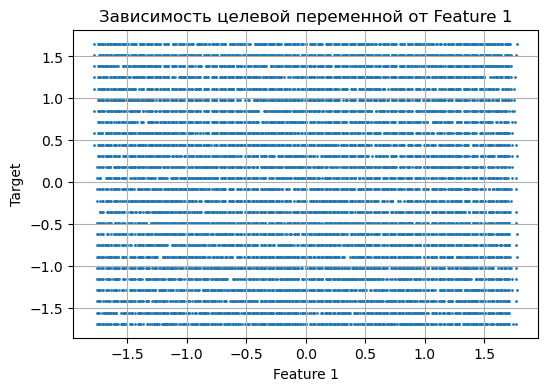

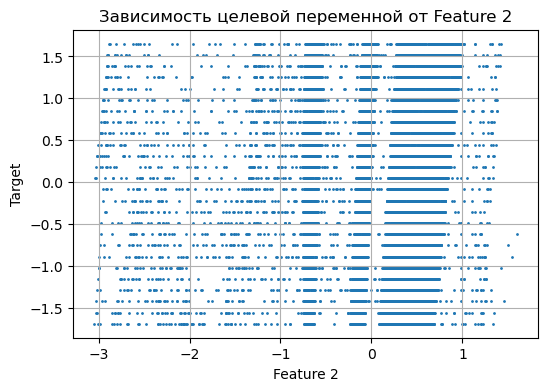

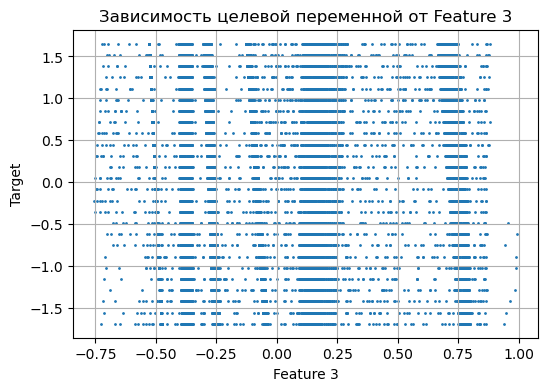

In [8]:
n_features = X_train_std.shape[1]

for i in range(n_features):
    plt.figure(figsize=(6,4))
    plt.scatter(X_train_std.iloc[:, i], y_train, s=1)
    plt.xlabel(f'Feature {i}')
    plt.ylabel('Target')
    plt.title(f'Зависимость целевой переменной от Feature {i}')
    plt.grid(True)
    plt.show()

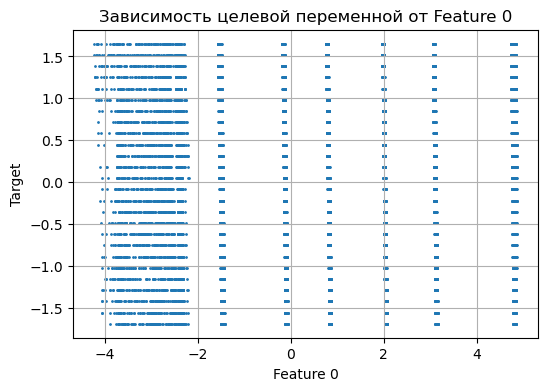

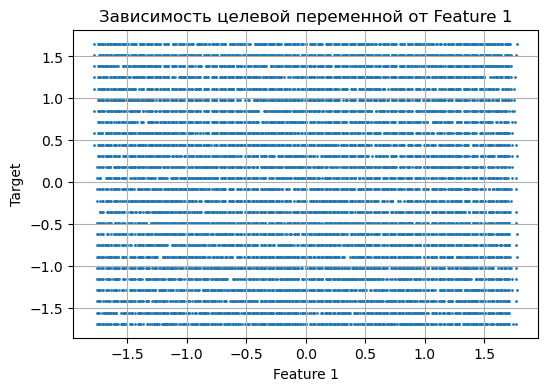

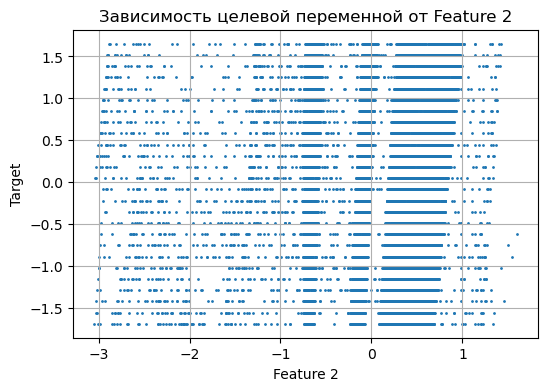

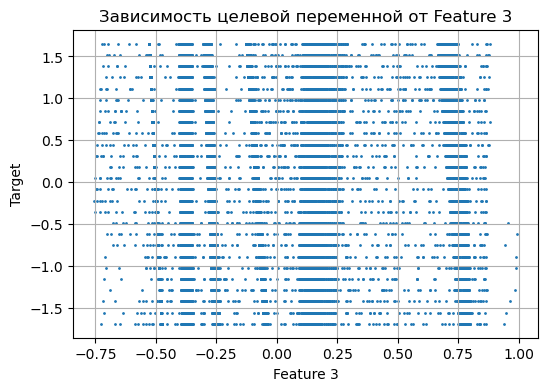

In [9]:
n_features = X_train_minmax.shape[1]

for i in range(n_features):
    plt.figure(figsize=(6,4))
    plt.scatter(X_train_minmax.iloc[:, i], y_train, s=1)
    plt.xlabel(f'Feature {i}')
    plt.ylabel('Target')
    plt.title(f'Зависимость целевой переменной от Feature {i}')
    plt.grid(True)
    plt.show()

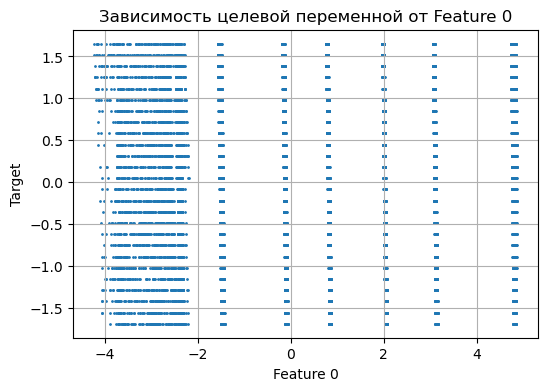

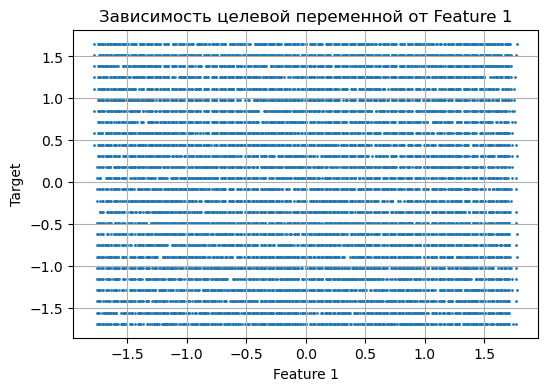

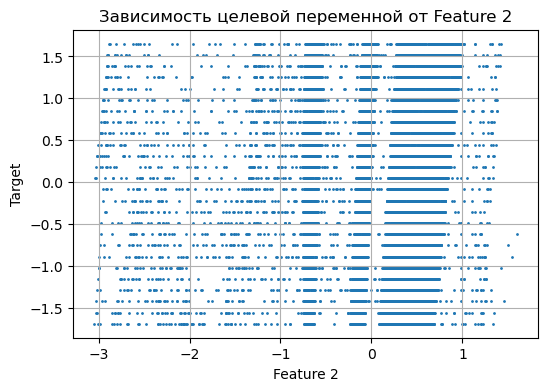

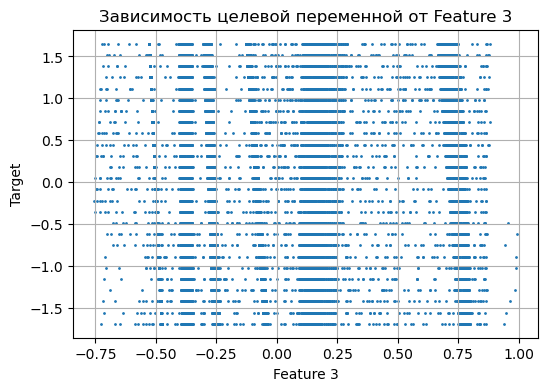

In [10]:
n_features = X_train_robust.shape[1]

for i in range(n_features):
    plt.figure(figsize=(6,4))
    plt.scatter(X_train_robust.iloc[:, i], y_train, s=1)
    plt.xlabel(f'Feature {i}')
    plt.ylabel('Target')
    plt.title(f'Зависимость целевой переменной от Feature {i}')
    plt.grid(True)
    plt.show()

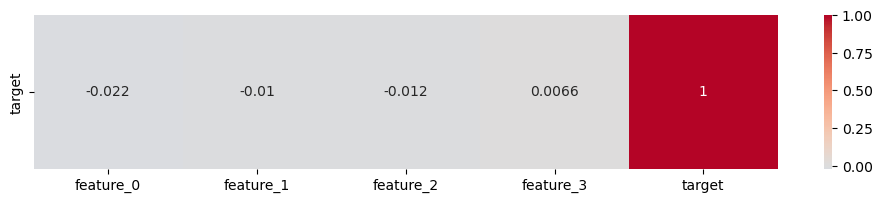

In [5]:
feature_names = [f"feature_{i}" for i in range(X_train.shape[1])]

df = pd.DataFrame(X_train, columns=feature_names)
df["target"] = y_train
corr_row = df.corr(numeric_only=True)[["target"]].T
plt.figure(figsize=(12, 2))
sns.heatmap(corr_row, annot=True, cmap="coolwarm", center=0)
plt.show()

# Выбор модели

Выберим следующие модели: Gradient Boosting, Random Forest, Ridge regression

Ridge regression выберим, чтобы сравинть с моделями Gradient Boosting, Random Forest, и посмотреть, насколько она ужасна

Метрики следующие: R2, MAPE. Такие метрики выбраны, потому что они относительны и позволяют оценить модель на таком придуманном датасете

In [29]:
import optuna
from catboost import CatBoostRegressor
from sklearn.metrics import r2_score, mean_absolute_percentage_error
from sklearn.model_selection import KFold, cross_validate

## CatBoost

In [18]:
import numpy as np
import optuna
from catboost import CatBoostRegressor
from sklearn.model_selection import KFold
from sklearn.metrics import r2_score, mean_absolute_percentage_error

In [12]:
datasets = {
    "Standard": X_train_std,
    "MinMax": X_train_minmax,
    "Robust": X_train_robust
}

In [32]:
final_results_cb = {}

def objective_cb(trial, X_data, y_data):
    params = {
        "iterations": trial.suggest_int("iterations", 500, 2000),
        "depth": trial.suggest_int("depth", 4, 10),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3, log=True),
        "l2_leaf_reg": trial.suggest_float("l2_leaf_reg", 1e-3, 10, log=True),
        "bagging_temperature": trial.suggest_float("bagging_temperature", 0.0, 1.0),
        "random_strength": trial.suggest_float("random_strength", 0.1, 10),
        "loss_function": "RMSE",
        "verbose": 0,
        "random_state": 42
    }

    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    cv_scores = []

    for train_idx, val_idx in kf.split(X_data, y_data):
        X_tr, X_val = X_data[train_idx], X_data[val_idx]
        y_tr, y_val = y_data[train_idx], y_data[val_idx]

        model = CatBoostRegressor(**params)
        model.fit(
            X_tr, y_tr,
            eval_set=(X_val, y_val),
            early_stopping_rounds=50,
            use_best_model=True,
            verbose=False
        )

        y_pred = model.predict(X_val)
        cv_scores.append(r2_score(y_val, y_pred))

    return np.mean(cv_scores)

In [34]:
for name, X_curr in datasets.items():
    print(f"\n{'='*30}")
    print(f"Оптимизация CatBoost для скалера: {name}")
    print(f"{'='*30}")

    study = optuna.create_study(direction="maximize")
    study.optimize(lambda trial: objective_cb(trial, X_curr, y_train), n_trials=5)

    best_params = study.best_params
    best_params.update({
        "loss_function": "RMSE",
        "verbose": 0,
        "random_state": 42
    })

    final_model = CatBoostRegressor(**best_params)

    scoring_metrics = {
        "r2": "r2",
        "mape": "neg_mean_absolute_percentage_error"
    }

    cv_results = cross_validate(
        final_model,
        X_curr,
        y_train,
        cv=5,
        scoring=scoring_metrics,
        n_jobs=-1
    )

    mean_r2 = np.mean(cv_results["test_r2"])
    mean_mape = -np.mean(cv_results["test_mape"])

    final_model.fit(X_curr, y_train)

    final_results_cb[name] = {
        "best_r2_cv": mean_r2,
        "best_mape_cv": mean_mape,
        "best_par": best_params
    }

print("\nИТОГОВЫЕ РЕЗУЛЬТАТЫ (CatBoost)")
for name, res in final_results_cb.items():
    print(f"{name:<15} | {res['best_r2_cv']:.4f}     | {res['best_mape_cv']:.2%}")

[I 2025-12-20 12:34:39,675] A new study created in memory with name: no-name-2a39544b-feb5-458c-be3e-688f93a1d5eb



Оптимизация CatBoost для скалера: Standard


[I 2025-12-20 12:34:57,749] Trial 0 finished with value: 0.9094668745713455 and parameters: {'iterations': 950, 'depth': 7, 'learning_rate': 0.022512718017793316, 'l2_leaf_reg': 0.14850289477436304, 'bagging_temperature': 0.32625093510515657, 'random_strength': 2.9678639106142493}. Best is trial 0 with value: 0.9094668745713455.
[I 2025-12-20 12:35:13,709] Trial 1 finished with value: 0.8765483346203942 and parameters: {'iterations': 1697, 'depth': 4, 'learning_rate': 0.02659441755205141, 'l2_leaf_reg': 0.07196838296192717, 'bagging_temperature': 0.5437604460998182, 'random_strength': 2.760996246483431}. Best is trial 0 with value: 0.9094668745713455.
[I 2025-12-20 12:35:22,720] Trial 2 finished with value: 0.9242742183395638 and parameters: {'iterations': 1058, 'depth': 6, 'learning_rate': 0.19354056757873397, 'l2_leaf_reg': 0.0010354619073801503, 'bagging_temperature': 0.16677916826107142, 'random_strength': 7.1423225719850265}. Best is trial 2 with value: 0.9242742183395638.
[I 2025


Оптимизация CatBoost для скалера: MinMax


[I 2025-12-20 12:37:13,558] Trial 0 finished with value: 0.9279673580964302 and parameters: {'iterations': 1955, 'depth': 6, 'learning_rate': 0.06828824316232471, 'l2_leaf_reg': 0.014464257860062484, 'bagging_temperature': 0.21602779791206217, 'random_strength': 7.072276744719075}. Best is trial 0 with value: 0.9279673580964302.
[I 2025-12-20 12:37:36,169] Trial 1 finished with value: 0.9281506747064204 and parameters: {'iterations': 1107, 'depth': 9, 'learning_rate': 0.20267036115357412, 'l2_leaf_reg': 0.00971632813306658, 'bagging_temperature': 0.553139496064833, 'random_strength': 5.980629543608088}. Best is trial 1 with value: 0.9281506747064204.
[I 2025-12-20 12:37:44,143] Trial 2 finished with value: 0.742063791808296 and parameters: {'iterations': 792, 'depth': 4, 'learning_rate': 0.017401668321298955, 'l2_leaf_reg': 0.11579049311488399, 'bagging_temperature': 0.31102053605806945, 'random_strength': 1.6344632273423456}. Best is trial 1 with value: 0.9281506747064204.
[I 2025-12-


Оптимизация CatBoost для скалера: Robust


[I 2025-12-20 12:40:13,200] Trial 0 finished with value: 0.934134505950907 and parameters: {'iterations': 1519, 'depth': 10, 'learning_rate': 0.04327307120711982, 'l2_leaf_reg': 0.0010723130292386973, 'bagging_temperature': 0.3130167014150633, 'random_strength': 1.8904260445555188}. Best is trial 0 with value: 0.934134505950907.
[I 2025-12-20 12:41:00,776] Trial 1 finished with value: 0.9316618253357317 and parameters: {'iterations': 1567, 'depth': 9, 'learning_rate': 0.05031265470176954, 'l2_leaf_reg': 0.008054682842960549, 'bagging_temperature': 0.4059155657811321, 'random_strength': 9.629990962750322}. Best is trial 0 with value: 0.934134505950907.
[I 2025-12-20 12:41:24,621] Trial 2 finished with value: 0.9264843709828252 and parameters: {'iterations': 1718, 'depth': 6, 'learning_rate': 0.03134398096592136, 'l2_leaf_reg': 0.020157748154806598, 'bagging_temperature': 0.48871377196814036, 'random_strength': 0.8164945303692565}. Best is trial 0 with value: 0.934134505950907.
[I 2025-1


ИТОГОВЫЕ РЕЗУЛЬТАТЫ (CatBoost)
Standard        | 0.9288     | 25.65%
MinMax          | 0.9215     | 26.44%
Robust          | 0.9293     | 24.29%


## Ridge

In [35]:
from sklearn.linear_model import Ridge

final_results_ridge = {}

def objective_ridge(trial, X_data, y_data):
    params = {
        "alpha": trial.suggest_float("alpha", 1e-3, 100.0, log=True),
        "random_state": 42
    }

    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    cv_scores = []

    for train_idx, val_idx in kf.split(X_data, y_data):
        X_tr, X_val = X_data[train_idx], X_data[val_idx]
        y_tr, y_val = y_data[train_idx], y_data[val_idx]

        model = Ridge(**params)
        model.fit(X_tr, y_tr)

        y_pred = model.predict(X_val)
        cv_scores.append(r2_score(y_val, y_pred))

    return np.mean(cv_scores)

In [38]:
for name, X_curr in datasets.items():
    print(f"\n{'='*30}")
    print(f"Оптимизация Ridge для скалера: {name}")
    print(f"{'='*30}")

    study = optuna.create_study(direction="maximize")
    study.optimize(lambda trial: objective_ridge(trial, X_curr, y_train), n_trials=20)

    best_params = study.best_params
    best_params.update({"random_state": 42})

    final_model = Ridge(**best_params)

    scoring_metrics = {
        "r2": "r2",
        "mape": "neg_mean_absolute_percentage_error"
    }

    cv_results = cross_validate(
        final_model,
        X_curr,
        y_train,
        cv=5,
        scoring=scoring_metrics,
        n_jobs=-1
    )

    mean_r2 = np.mean(cv_results["test_r2"])
    mean_mape = -np.mean(cv_results["test_mape"])

    final_model.fit(X_curr, y_train)

    final_results_ridge[name] = {
        "best_r2_cv": mean_r2,
        "best_mape_cv": mean_mape,
        "best_par": best_params
    }
    
print("\nИТОГОВЫЕ РЕЗУЛЬТАТЫ (Ridge)")
print(f"{'Scaler':<15} | {'R2':<10} | {'MAPE':<10}")
print("-" * 40)
for name, res in final_results_ridge.items():
    print(f"{name:<15} | {res['best_r2_cv']:.4f}     | {res['best_mape_cv']:.2%}")

[I 2025-12-20 12:47:59,345] A new study created in memory with name: no-name-9beda047-d9e0-453d-a8ae-6d2a1f5e1165
[I 2025-12-20 12:47:59,367] Trial 0 finished with value: 0.003894461282977413 and parameters: {'alpha': 0.08185349633682257}. Best is trial 0 with value: 0.003894461282977413.
[I 2025-12-20 12:47:59,389] Trial 1 finished with value: 0.0038971296476943305 and parameters: {'alpha': 15.157621370565868}. Best is trial 1 with value: 0.0038971296476943305.
[I 2025-12-20 12:47:59,412] Trial 2 finished with value: 0.00389445880651631 and parameters: {'alpha': 0.0686862212502256}. Best is trial 1 with value: 0.0038971296476943305.
[I 2025-12-20 12:47:59,436] Trial 3 finished with value: 0.0038944560722609543 and parameters: {'alpha': 0.05414986352550514}. Best is trial 1 with value: 0.0038971296476943305.
[I 2025-12-20 12:47:59,458] Trial 4 finished with value: 0.0038944467564109076 and parameters: {'alpha': 0.004635828654969583}. Best is trial 1 with value: 0.0038971296476943305.
[


Оптимизация Ridge для скалера: Standard


[I 2025-12-20 12:47:59,543] Trial 8 finished with value: 0.003894446151447406 and parameters: {'alpha': 0.0014211031408639166}. Best is trial 1 with value: 0.0038971296476943305.
[I 2025-12-20 12:47:59,563] Trial 9 finished with value: 0.0038944463510528714 and parameters: {'alpha': 0.0024817807070468432}. Best is trial 1 with value: 0.0038971296476943305.
[I 2025-12-20 12:47:59,586] Trial 10 finished with value: 0.003902272570847276 and parameters: {'alpha': 51.47840128757132}. Best is trial 10 with value: 0.003902272570847276.
[I 2025-12-20 12:47:59,608] Trial 11 finished with value: 0.0039050586775435823 and parameters: {'alpha': 78.84507918767326}. Best is trial 11 with value: 0.0039050586775435823.
[I 2025-12-20 12:47:59,636] Trial 12 finished with value: 0.0039055876512437806 and parameters: {'alpha': 85.26076148316771}. Best is trial 12 with value: 0.0039055876512437806.
[I 2025-12-20 12:47:59,659] Trial 13 finished with value: 0.0038951298250257116 and parameters: {'alpha': 3.6


Оптимизация Ridge для скалера: MinMax


[I 2025-12-20 12:48:00,031] Trial 10 finished with value: 0.003894448873096512 and parameters: {'alpha': 0.01588436679075911}. Best is trial 2 with value: 0.003904588170531298.
[I 2025-12-20 12:48:00,053] Trial 11 finished with value: 0.003906521184737821 and parameters: {'alpha': 98.2352399288133}. Best is trial 11 with value: 0.003906521184737821.
[I 2025-12-20 12:48:00,076] Trial 12 finished with value: 0.0039062114671128967 and parameters: {'alpha': 93.6462366556192}. Best is trial 11 with value: 0.003906521184737821.
[I 2025-12-20 12:48:00,099] Trial 13 finished with value: 0.0039028813536445828 and parameters: {'alpha': 56.77703498996963}. Best is trial 11 with value: 0.003906521184737821.
[I 2025-12-20 12:48:00,121] Trial 14 finished with value: 0.0038947480908596787 and parameters: {'alpha': 1.6162341758981367}. Best is trial 11 with value: 0.003906521184737821.
[I 2025-12-20 12:48:00,146] Trial 15 finished with value: 0.003906237905890575 and parameters: {'alpha': 94.025520842


Оптимизация Ridge для скалера: Robust


[I 2025-12-20 12:48:00,460] Trial 8 finished with value: 0.003894487237125266 and parameters: {'alpha': 0.2199340775365576}. Best is trial 6 with value: 0.0039010497084965403.
[I 2025-12-20 12:48:00,479] Trial 9 finished with value: 0.0038944675437735166 and parameters: {'alpha': 0.11514813139583188}. Best is trial 6 with value: 0.0039010497084965403.
[I 2025-12-20 12:48:00,498] Trial 10 finished with value: 0.0039051132912869104 and parameters: {'alpha': 79.48272194530735}. Best is trial 10 with value: 0.0039051132912869104.
[I 2025-12-20 12:48:00,518] Trial 11 finished with value: 0.0039046838746839897 and parameters: {'alpha': 74.60452709407866}. Best is trial 10 with value: 0.0039051132912869104.
[I 2025-12-20 12:48:00,537] Trial 12 finished with value: 0.003906268244516698 and parameters: {'alpha': 94.46346590970236}. Best is trial 12 with value: 0.003906268244516698.
[I 2025-12-20 12:48:00,558] Trial 13 finished with value: 0.003895697189914604 and parameters: {'alpha': 6.8333353


ИТОГОВЫЕ РЕЗУЛЬТАТЫ (Ridge)
Scaler          | R2         | MAPE      
----------------------------------------
Standard        | 0.0037     | 100.98%
MinMax          | 0.0037     | 100.98%
Robust          | 0.0037     | 100.98%


## Random Forest

In [31]:
from sklearn.ensemble import RandomForestRegressor

In [27]:
final_results_rf = {}

def objective_rf(trial, X_data, y_data):
    params = {
        "n_estimators": trial.suggest_int("n_estimators", 50, 500),
        "max_depth": trial.suggest_int("max_depth", 5, 30),
        "min_samples_split": trial.suggest_int("min_samples_split", 2, 20),
        "min_samples_leaf": trial.suggest_int("min_samples_leaf", 1, 10),
        "n_jobs": -1,
        "random_state": 42
    }

    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    cv_scores = []

    for train_idx, val_idx in kf.split(X_data, y_data):
        X_tr, X_val = X_data[train_idx], X_data[val_idx]
        y_tr, y_val = y_data[train_idx], y_data[val_idx]

        model = RandomForestRegressor(**params)
        model.fit(X_tr, y_tr)

        y_pred = model.predict(X_val)
        cv_scores.append(r2_score(y_val, y_pred))

    return np.mean(cv_scores)

In [30]:
for name, X_curr in datasets.items():
    print(f"\n{'='*30}")
    print(f"Оптимизация Random Forest для скалера: {name}")
    print(f"{'='*30}")

    study = optuna.create_study(direction="maximize")
    study.optimize(lambda trial: objective_rf(trial, X_curr, y_train), n_trials=10)

    best_params = study.best_params
    best_params.update({"n_jobs": -1, "random_state": 42})
    
    final_model = RandomForestRegressor(**best_params)
    scoring_metrics = {
        'r2': 'r2',
        'mape': 'neg_mean_absolute_percentage_error' 
    }
    
    cv_results = cross_validate(
        final_model, 
        X_curr, 
        y_train, 
        cv=5, 
        scoring=scoring_metrics, 
        n_jobs=-1
    )

    mean_r2 = np.mean(cv_results['test_r2'])
    mean_mape = -np.mean(cv_results['test_mape'])

    final_model.fit(X_curr, y_train)

    final_results_rf[name] = {
        "best_r2_cv": mean_r2,
        "best_mape_cv": mean_mape,
        "best_par": best_params
    }

print("\nИТОГОВЫЕ РЕЗУЛЬТАТЫ (Random Forest)")
print(f"{'Scaler':<15} | {'R2':<10} | {'MAPE':<10}")
print("-" * 40)
for name, res in final_results_rf.items():
    print(f"{name:<15} | {res['best_r2_cv']:.4f}     | {res['best_mape_cv']:.2%}")

[I 2025-12-20 12:19:53,877] A new study created in memory with name: no-name-bea6fdba-27a0-47e3-aa17-547018660346



Оптимизация Random Forest для скалера: Standard


[I 2025-12-20 12:19:58,805] Trial 0 finished with value: 0.8961149503868787 and parameters: {'n_estimators': 250, 'max_depth': 19, 'min_samples_split': 14, 'min_samples_leaf': 10}. Best is trial 0 with value: 0.8961149503868787.
[I 2025-12-20 12:20:05,438] Trial 1 finished with value: 0.8635776084869896 and parameters: {'n_estimators': 367, 'max_depth': 11, 'min_samples_split': 10, 'min_samples_leaf': 7}. Best is trial 0 with value: 0.8961149503868787.
[I 2025-12-20 12:20:12,169] Trial 2 finished with value: 0.6152006705454908 and parameters: {'n_estimators': 459, 'max_depth': 7, 'min_samples_split': 3, 'min_samples_leaf': 7}. Best is trial 0 with value: 0.8961149503868787.
[I 2025-12-20 12:20:19,999] Trial 3 finished with value: 0.9167863431742154 and parameters: {'n_estimators': 389, 'max_depth': 22, 'min_samples_split': 9, 'min_samples_leaf': 5}. Best is trial 3 with value: 0.9167863431742154.
[I 2025-12-20 12:20:23,715] Trial 4 finished with value: 0.904040853964803 and parameters:


Оптимизация Random Forest для скалера: MinMax


[I 2025-12-20 12:21:02,486] Trial 0 finished with value: 0.9311924809183114 and parameters: {'n_estimators': 347, 'max_depth': 27, 'min_samples_split': 4, 'min_samples_leaf': 1}. Best is trial 0 with value: 0.9311924809183114.
[I 2025-12-20 12:21:04,047] Trial 1 finished with value: 0.9026762250541956 and parameters: {'n_estimators': 59, 'max_depth': 30, 'min_samples_split': 3, 'min_samples_leaf': 8}. Best is trial 0 with value: 0.9311924809183114.
[I 2025-12-20 12:21:07,428] Trial 2 finished with value: 0.8430565026556286 and parameters: {'n_estimators': 179, 'max_depth': 10, 'min_samples_split': 2, 'min_samples_leaf': 1}. Best is trial 0 with value: 0.9311924809183114.
[I 2025-12-20 12:21:10,541] Trial 3 finished with value: 0.9080223320771463 and parameters: {'n_estimators': 146, 'max_depth': 25, 'min_samples_split': 5, 'min_samples_leaf': 7}. Best is trial 0 with value: 0.9311924809183114.
[I 2025-12-20 12:21:19,445] Trial 4 finished with value: 0.9077927885727833 and parameters: {


Оптимизация Random Forest для скалера: Robust


[I 2025-12-20 12:21:51,226] Trial 0 finished with value: 0.9038312229460066 and parameters: {'n_estimators': 112, 'max_depth': 23, 'min_samples_split': 9, 'min_samples_leaf': 8}. Best is trial 0 with value: 0.9038312229460066.
[I 2025-12-20 12:21:56,491] Trial 1 finished with value: 0.5046192135376751 and parameters: {'n_estimators': 393, 'max_depth': 6, 'min_samples_split': 9, 'min_samples_leaf': 4}. Best is trial 0 with value: 0.9038312229460066.
[I 2025-12-20 12:22:01,720] Trial 2 finished with value: 0.9095630357449357 and parameters: {'n_estimators': 262, 'max_depth': 21, 'min_samples_split': 19, 'min_samples_leaf': 2}. Best is trial 2 with value: 0.9095630357449357.
[I 2025-12-20 12:22:07,290] Trial 3 finished with value: 0.389704799791972 and parameters: {'n_estimators': 446, 'max_depth': 5, 'min_samples_split': 15, 'min_samples_leaf': 3}. Best is trial 2 with value: 0.9095630357449357.
[I 2025-12-20 12:22:15,073] Trial 4 finished with value: 0.9128141152674711 and parameters: {


ИТОГОВЫЕ РЕЗУЛЬТАТЫ (Random Forest)
Scaler          | R2         | MAPE      
----------------------------------------
Standard        | 0.9142     | 25.80%
MinMax          | 0.9284     | 22.54%
Robust          | 0.9225     | 24.96%


| **Модель**    | **Scaler** | **R2** | **MAPE, %** |
| ------------- | ---------- | -----: | ----------: |
| CatBoost      | Standard   | 0.9288 |       25.65 |
| CatBoost      | MinMax     | 0.9215 |       26.44 |
| CatBoost      | Robust     | 0.9293 |       24.29 |
| Random Forest | Standard   | 0.9142 |       25.80 |
| Random Forest | MinMax     | 0.9284 |       22.54 |
| Random Forest | Robust     | 0.9225 |       24.96 |
| Ridge         | Standard   | 0.0037 |      100.98 |
| Ridge         | MinMax     | 0.0037 |      100.98 |
| Ridge         | Robust     | 0.0037 |      100.98 |


Лучше всех оказались древовидные ансамблевые модели, что неудивительно, так как зачастую они показвывают себя очень хорошо. Линейная модель не справилась с задачей, так как в признаках отсутствуют линейные зависимости с целевым признаком